In [1]:
# Свёрточная нейронная сеть (CNN)

from __future__ import absolute_import, division, print_function, unicode_literals

# Импорт TensorFlow и TensorFlow DataSets
import tensorflow as tf
import tensorflow_datasets as tfds

# Импортируем вспомогательные библиотеки
import math
import numpy as np
import matplotlib.pyplot as plt

# Улучшение отображения прогрессбара
import tqdm
import tqdm.auto
tqdm.tqdm = tqdm.auto.tqdm

In [2]:
# Загрузка датасета
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

In [3]:
# Наименования классов одежды / обуви
class_names = ["Футболка / топ", "Шорты", "Свитер", "Платье", "Плащ", "Сандали", "Рубашка", "Кроссовок", "Сумка", "Ботинок"]

In [4]:
# Вывод числа тренировочных и тестовых изображений
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print('Количество тренировочных экземпляров: {}'.format(num_train_examples))
print('Количество тестовых экземпляров: {}'.format(num_test_examples))

Количество тренировочных экземпляров: 60000
Количество тестовых экземпляров: 10000


In [7]:
# Обратим внимание - не была проведена нормализация изображений
# Создание модели и слоёв
model = tf.keras.Sequential([
    # Сначала идёт свёрточный слой, принимающий входное изображение
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu, input_shape=(28, 28, 1)),
    # 32 - выходные фильтры в свёртке, (3,3) - размер ядра, padding='same' - заполнение матрицы за пределами изображения
    # Далее идёт слой подвыборки (pooling layer)
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    # (2, 2) - коэффициенты уменьшения изображения по высоте и ширине, изображение уменьшится в 2 раза
    # strides=2 - шаги уменьшения. Далее идёт повтор этих же шагов
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    # Сглаживающий слой для переноса информации в вектор
    tf.keras.layers.Flatten(),
    # Плотносвязные слои: один для внутренних вычислений, второй для вывода
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10,  activation=tf.nn.softmax)
])

In [8]:
# Компиляция модели
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# Тренировка модели
BATCH_SIZE = 32
train_dataset = train_dataset.repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)
model.fit(train_dataset, epochs=5, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/5
1875/1875 [==============================] - 115s 61ms/step - loss: 0.5377 - accuracy: 0.8527
Epoch 2/5
1875/1875 [==============================] - 95s 51ms/step - loss: 0.2892 - accuracy: 0.89300s - loss: 0.289
Epoch 3/5
1875/1875 [==============================] - 99s 53ms/step - loss: 0.2465 - accuracy: 0.9096
Epoch 4/5
1875/1875 [==============================] - 102s 54ms/step - loss: 0.2172 - accuracy: 0.9202
Epoch 5/5
1875/1875 [==============================] - 102s 55ms/step - loss: 0.1997 - accuracy: 0.9256


In [9]:
# Проверка точности на тестовом наборе данных
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/BATCH_SIZE))
print("Точность на тестовом наборе данных: ", test_accuracy)

313/313 [==============================] - 5s 17ms/step - loss: 0.3192 - accuracy: 0.8981
Точность на тестовом наборе данных:  0.8981000185012817


In [10]:
# Дополнительные функции для вывода информации с использованием matplotlib

def plot_image(i, predictions_array, true_label, images):
    predictions_array, true_label, img = predictions_array[i], true_label[i], images[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img[...,0], cmap=plt.cm.binary)
    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                      100 * np.max(predictions_array),
                                      class_names[true_label]),
                                      color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

In [12]:
# Модель предсказывает метки для тестовых изображений
for test_images, test_labels in test_dataset.take(1):
    test_images = test_images.numpy()
    test_labels = test_labels.numpy()
    predictions = model.predict(test_images)
predictions.shape

(32, 10)

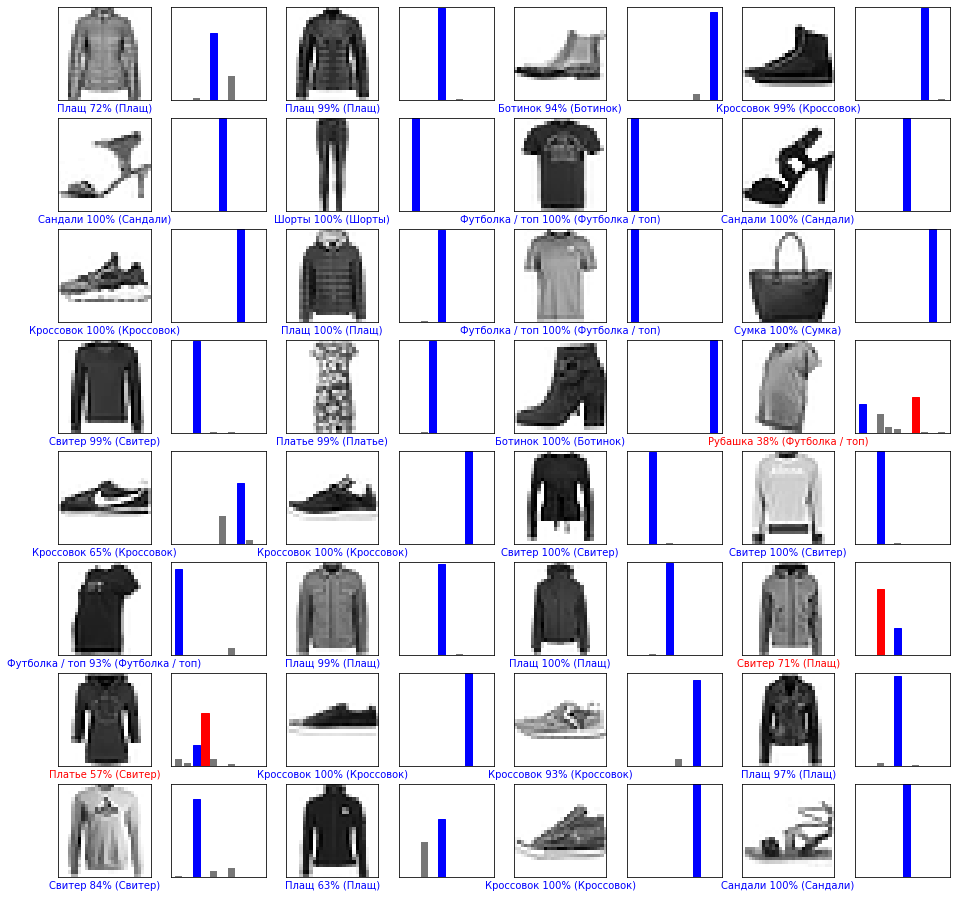

In [21]:
# Отображение нескольких изображений и предсказаний сети о них
num_rows = 8
num_cols = 4
num_images = num_rows * num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i + 1)
    plot_image(i, predictions, test_labels, test_images)
    plt.subplot(num_rows, 2*num_cols, 2*i + 2)
    plot_value_array(i, predictions, test_labels)

In [22]:
# Сохранение модели в станадарт HDF5

from keras.models import load_model

model.save('Third_network_CNN_model.h5')

# Затем можно будет загрузить с помощью команды model = load_model(‘my_model.h5’)